In [2]:
from scipy.io import netcdf
import scipy
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
#import AMM60_tools  # I think that we have done away with this file and called it amm60_data_tools.py
%matplotlib inline

/Users/jeff/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


AMM60_tools.py is obsolete. It was replaced by amm60_data_tools.py, which lives in FASTNEt. Hopefully these changes will work seemlessly for you.

In [3]:
import sys
sys.path.append('../FASTNEt/') # Add the directory with the amm60_data_tools.py file to path
import amm60_data_tools # The new AMM60_tools

########################################
# Check username.
# Depending on username modify path tree

import getpass
username = getpass.getuser()

if username in ['jeff','jelt']:
    dirpath = '../FASTNEt/'
elif username in ['karen','kariho40']:
    dirpath = '/media/data1/AMM60/FASTNEt/'
else:
    dirpath = '../FASTNEt/'

print 'Karen, Hopefully your username is  correct here and your paths will be maintained. Though hopefully this should also work if you download the whole project'


Karen, Hopefully your username is  correct here and your paths will be maintained. Though hopefully this should also work if you download the whole project


## Extract the thermocline depth (depth of the 13C isotherm) for St1 Celtic sea mooring ##

In [4]:
mooring_num = 'ST1'
max_depth = 150
len_seg = 256

In [5]:
def find_segment(filename):
    # Get the min/max index of available data.
    delta_obs = amm60_data_tools.readMODELnc(filename,'delta_nt_obs')
    delta_obs = np.ma.masked_where(delta_obs == 0, delta_obs)
    delta_obs = np.ma.masked_invalid(delta_obs)
    Index_start = np.argwhere(delta_obs)[0]
    Index_end = np.argwhere(delta_obs)[-1]
    
    return[Index_start,Index_end]

def compute_fft(filename,Index_start,Index_end):
    ### Load the data ###
    delta_obs = amm60_data_tools.readMODELnc(filename,'delta_obs')[Index_start:Index_end]
    delta_mod = amm60_data_tools.readMODELnc(filename,'delta_mod')[Index_start:Index_end]
    delta_3d_obs = amm60_data_tools.readMODELnc(filename,'delta_nt_obs')[Index_start:Index_end]
    delta_3d_mod = amm60_data_tools.readMODELnc(filename,'delta_nt_mod')[Index_start:Index_end]

    ### FFT ###
    print(len(delta_mod))
    fftobs = np.zeros((int(len_seg/2)+1,len(delta_mod)))
    fftmod = np.zeros((int(len_seg/2)+1,len(delta_mod)))
    f, fftobs = scipy.signal.welch(delta_obs-delta_3d_obs, fs=1.0, window='hanning', nperseg=len_seg, noverlap=len_seg*2/3, nfft=2*len_seg, detrend='linear', return_onesided=True, scaling='density')    
    f, fftmod = scipy.signal.welch(delta_mod-delta_3d_mod, fs=1.0, window='hanning', nperseg=len_seg, noverlap=len_seg*2/3, nfft=2*len_seg, detrend='linear', return_onesided=True, scaling='density')

    return[f,fftobs,fftmod]

In [6]:
###### AMM60 #####
print('AMM60')
filename = dirpath+'AMM60/mooring_'+mooring_num+'.nc'
[Index_start,Index_end] = find_segment(filename)
[famm60,fftobsamm60,fftmodamm60 ] = compute_fft(filename,Index_start,Index_end)

print(fftobsamm60.mean())
print(fftmodamm60.mean())

AMM60
329
50.8488
42.5223


/Users/jeff/anaconda/lib/python2.7/site-packages/scipy/io/netcdf.py:297: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)
/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/jeff/anaco

In [7]:
###### AMM7 #####
# read first time to extract the same period as AMM60
filename = dirpath+'AMM7/mooring_'+mooring_num+'.nc'
[Index_start,Index_end] = find_segment(filename)
[famm7,fftobsamm7,fftmodamm7 ] = compute_fft(filename,Index_start,Index_end)

print(fftobsamm7.mean())
print(fftmodamm7.mean())


329
53.0487
12.1194


/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [8]:
###### NNA #####
# read first time to extract the same period as AMM60
filename = dirpath+'NNA/mooring_'+mooring_num+'.nc'
[Index_start,Index_end] = find_segment(filename)
[fnna,fftobsnna,fftmodnna ] = compute_fft(filename,Index_start,Index_end)

print(fftobsnna.mean())
print(fftmodnna.mean())

329
57.7359
15.3188


/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


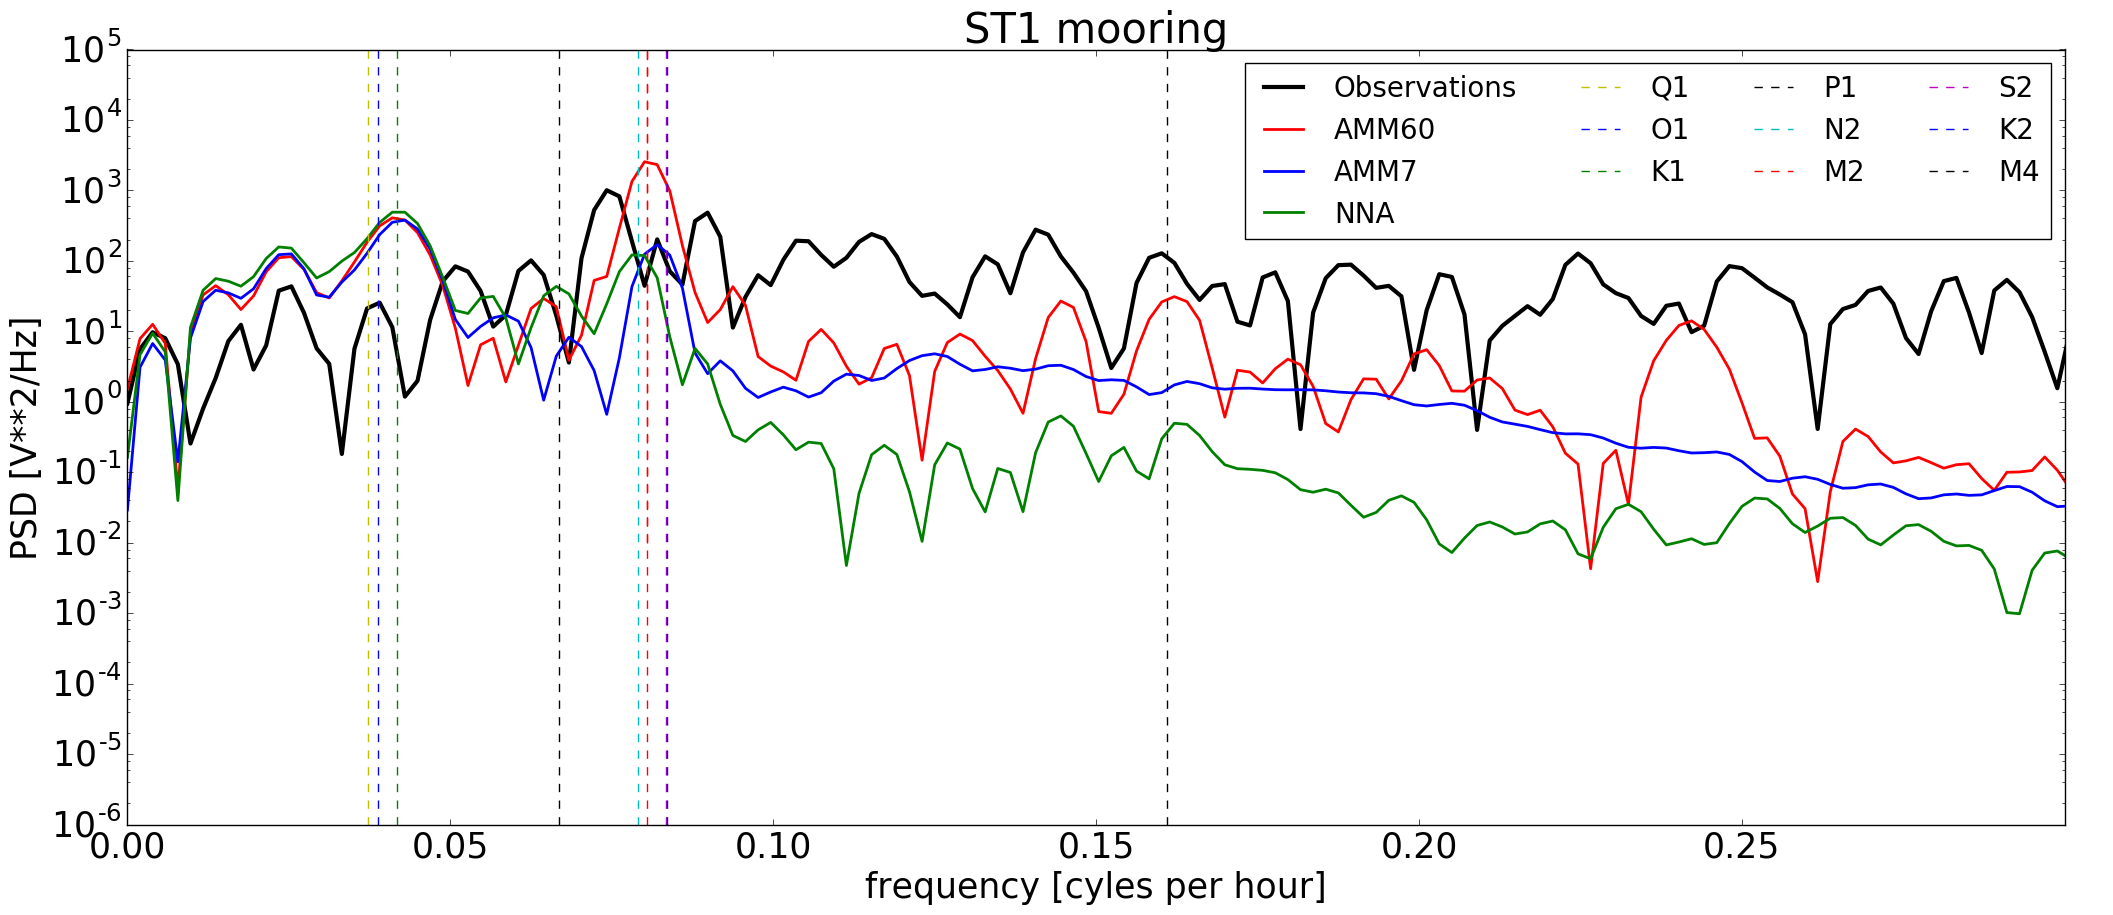

In [10]:
plt.figure(figsize=(25, 10), dpi=250, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})

period_hrs = 12.42; lineformat = 'r--'; label='M2'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-2, 1E7], lineformat)
#ax.text(1/(3600*period_hrs), 1E6, label)

plt.semilogy(famm60,fftobsamm60,color='k',label='Observations',linewidth=3)
plt.semilogy(famm60,fftmodamm60,color='r',label='AMM60',linewidth=2)
plt.semilogy(famm7,fftmodamm7,color='b',label='AMM7',linewidth=2)
plt.semilogy(fnna,fftmodnna,color='g',label='NNA',linewidth=2)

#period_hrs = 312.00; lineformat = 'k--'; label='M2-S2'
#plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='M2-S2')

period_hrs = 26.87; lineformat = 'y--'; label='Q1'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='Q1')

period_hrs = 25.82; lineformat = 'b--'; label='O1'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='O1')

period_hrs = 23.93; lineformat = 'g--'; label='K1'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='K1')

period_hrs = 14.96; lineformat = 'k--'; label='P1'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='P1')

period_hrs = 12.66; lineformat = 'c--'; label='N2'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='N2')

period_hrs = 12.42; lineformat = 'r--'; label='M2'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='M2')

period_hrs = 12.00; lineformat = 'm--'; label='S2'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='S2')

period_hrs = 11.967; lineformat = 'b--'; label='N2'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='K2')

period_hrs = 6.21; lineformat = 'k--'; label='M4'
plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='M4')






plt.xlim([0,0.3])
plt.ylim([1E-6, 1E5])
plt.title(mooring_num+' mooring')
if (mooring_num == 'ST1'):
    plt.legend(fontsize=20, loc='upper right', ncol=4)
plt.xlabel('frequency [cyles per hour]')
plt.ylabel('PSD [V**2/Hz]')

name = 'fft_'+mooring_num+'.png'
plt.savefig(str(name))

plt.show()


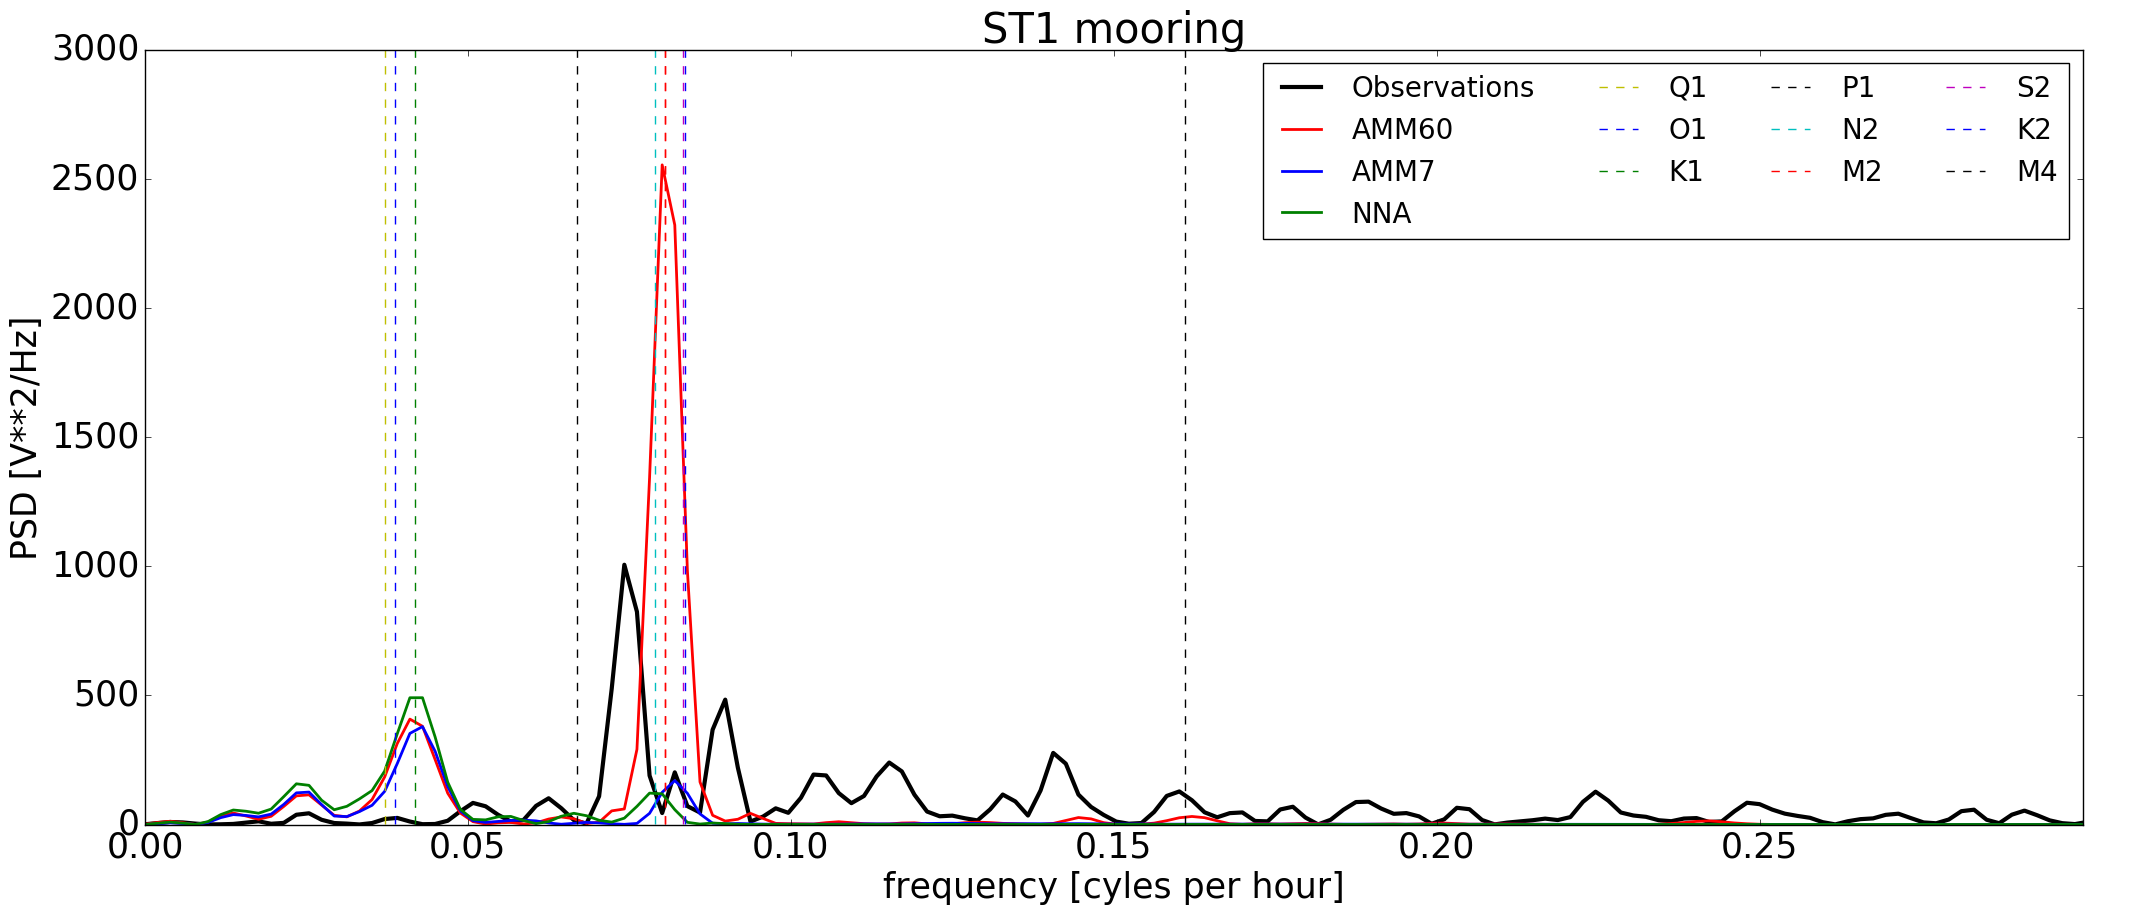

In [12]:
plt.figure(figsize=(25, 10), dpi=250, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})

period_hrs = 12.42; lineformat = 'r--'; label='M2'
plt.plot( [1/period_hrs, 1/period_hrs], [1E-2, 1E7], lineformat)
#ax.text(1/(3600*period_hrs), 1E6, label)

plt.plot(famm60,fftobsamm60,color='k',label='Observations',linewidth=3)
plt.plot(famm60,fftmodamm60,color='r',label='AMM60',linewidth=2)
plt.plot(famm7,fftmodamm7,color='b',label='AMM7',linewidth=2)
plt.plot(fnna,fftmodnna,color='g',label='NNA',linewidth=2)

#period_hrs = 312.00; lineformat = 'k--'; label='M2-S2'
#plt.semilogy( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='M2-S2')

period_hrs = 26.87; lineformat = 'y--'; label='Q1'
plt.plot( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='Q1')

period_hrs = 25.82; lineformat = 'b--'; label='O1'
plt.plot( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='O1')

period_hrs = 23.93; lineformat = 'g--'; label='K1'
plt.plot( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='K1')

period_hrs = 14.96; lineformat = 'k--'; label='P1'
plt.plot( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='P1')

period_hrs = 12.66; lineformat = 'c--'; label='N2'
plt.plot( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='N2')

period_hrs = 12.42; lineformat = 'r--'; label='M2'
plt.plot( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='M2')

period_hrs = 12.00; lineformat = 'm--'; label='S2'
plt.plot( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='S2')

period_hrs = 11.967; lineformat = 'b--'; label='N2'
plt.plot( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='K2')

period_hrs = 6.21; lineformat = 'k--'; label='M4'
plt.plot( [1/period_hrs, 1/period_hrs], [1E-6, 1E7], lineformat,label='M4')



plt.xlim([0,0.3])
plt.ylim([0, 3E3])
plt.title(mooring_num+' mooring')
if (mooring_num == 'ST1'):
    plt.legend(fontsize=20, loc='upper right', ncol=4)
plt.xlabel('frequency [cyles per hour]')
plt.ylabel('PSD [V**2/Hz]')

name = 'fft_'+mooring_num+'.png'
plt.savefig(str(name))

plt.show()
